# **Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

# **Aprendizaje Supervisado**

## Entregable: PARTE 2

## GRUPO Nº24

## INTEGRANTES:
   - Clarisa Manzone
   - Nico Rosales
   - Daniel Rubio
   - Diana Fonnegra
   -----

# Continuación: Análisis Exploratorio y Curación de Datos
-----

### Importación de módulos

In [115]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from scipy.stats import norm

from sklearn.experimental import enable_iterative_imputer

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer

from sklearn.decomposition import PCA

from sklearn.model_selection import cross_val_score, cross_validate, KFold, StratifiedKFold, \
    LeaveOneOut, LeavePOut,train_test_split, GridSearchCV, StratifiedKFold

from sklearn.metrics import recall_score, accuracy_score, precision_score, \
    f1_score, roc_auc_score, mean_squared_error, r2_score, confusion_matrix, \
    classification_report, ConfusionMatrixDisplay, accuracy_score, ConfusionMatrixDisplay, \
    classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC

import missingno as msno

sns.set_context('talk')
warnings.filterwarnings("ignore")

### Lectura del dataset

In [116]:
# Carga de los datasets (train y test)
train_titanic = pd.read_csv('CK_train.csv')
test_titanic = pd.read_csv('CK_test.csv')

In [117]:
# Extracción de las etiquetas a resguardo
y = train_titanic['Transported']

#### g_dataset
 - El g_dataset es la unión de ambos grupos de datos, eliminando previamente la etiqueta en el set etrenamiento
 - Nos permitira tener una vision global de todo el espacio de los atributos.
 - Sobre el mismo realizaremos las imputaciones por faltantes.

In [118]:
g_dataset = train_titanic.copy()
g_dataset.drop(['Transported'],axis=1, inplace=True)
g_dataset = g_dataset.append(test_titanic)

In [119]:
# dimensiones de cada grupo de datos
train_titanic.shape, test_titanic.shape, g_dataset.shape

((7823, 14), (870, 13), (8693, 13))

## Curado de datos

### Age
 - Variable numérica.
 - Categorizaremos la variable por rango a fin de modelar con impacto en el predictor la distribución bimodal que muestra el analisis exploratirio.
 - La categoría Unknown  corresponde  a los pasajeros que no tiene registro de edad.

In [120]:
g_dataset["Age"] = g_dataset["Age"].fillna(-0.5)
# Los rango y bins tratan de ser abarcativos, y los lables son propuestos sin mayor rigurosidad.
bins = [-1, 0, 5, 10, 15, 25, 30, 35, 40, 60, np.inf]
labels = ['Unknown', 'Kinder', 'School', 'HightSchool', 'Student', 'Young' ,'YoungAdult',
          'Adult', 'Father', 'GrandFather']

# Aplicamos la segmentación con Pandas
g_dataset['Age_Grouped'] = pd.cut(g_dataset["Age"], bins, labels = labels)
g_dataset.drop(['Age'], errors='ignore', axis=1, inplace=True)
g_dataset['Age_Grouped'].head(4)

0        Father
1       Student
2    YoungAdult
3        Father
Name: Age_Grouped, dtype: category
Categories (10, object): ['Unknown' < 'Kinder' < 'School' < 'HightSchool' ... 'YoungAdult' < 'Adult' < 'Father' < 'GrandFather']

### Name
 - Del atributo Name, a fin de simplificar el modelado, mantenemos solo el apellido

In [121]:
#Separamos nombre y apellido
name_split = g_dataset['Name'].str.split(' ', expand=True)
g_dataset['FamilyName'] = name_split[1]
g_dataset.drop('Name', inplace=True, axis=1)

## RoomService, FoodCourt, ShoppingMall, Spa, VRDeck
 - Agregamos una nueva variable amenities con la suma de las restantes. La propuesta es generar una dimensionalidad en el set de datos que resuma el conjuntos de gastos realizados por el pasajero.

In [122]:
amenities = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
g_dataset['TotalFee'] =g_dataset[amenities].sum(axis=1)

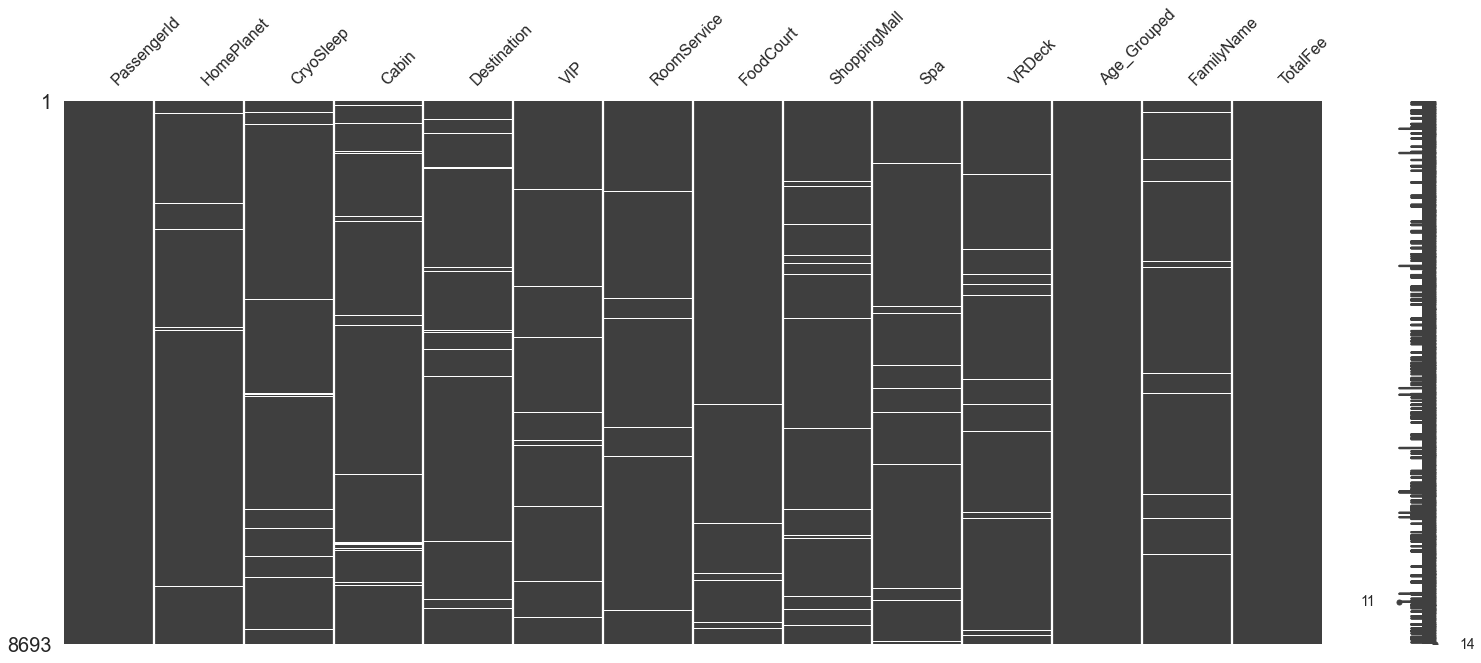

In [123]:
msno.matrix(g_dataset);

### Cabin
 - Se generaran tres nuevas variables que describe por separado la ubicación del pasajero en la nave

In [124]:
g_dataset.Cabin.head(3)

0    C/123/P
1    F/126/S
2    B/343/S
Name: Cabin, dtype: object

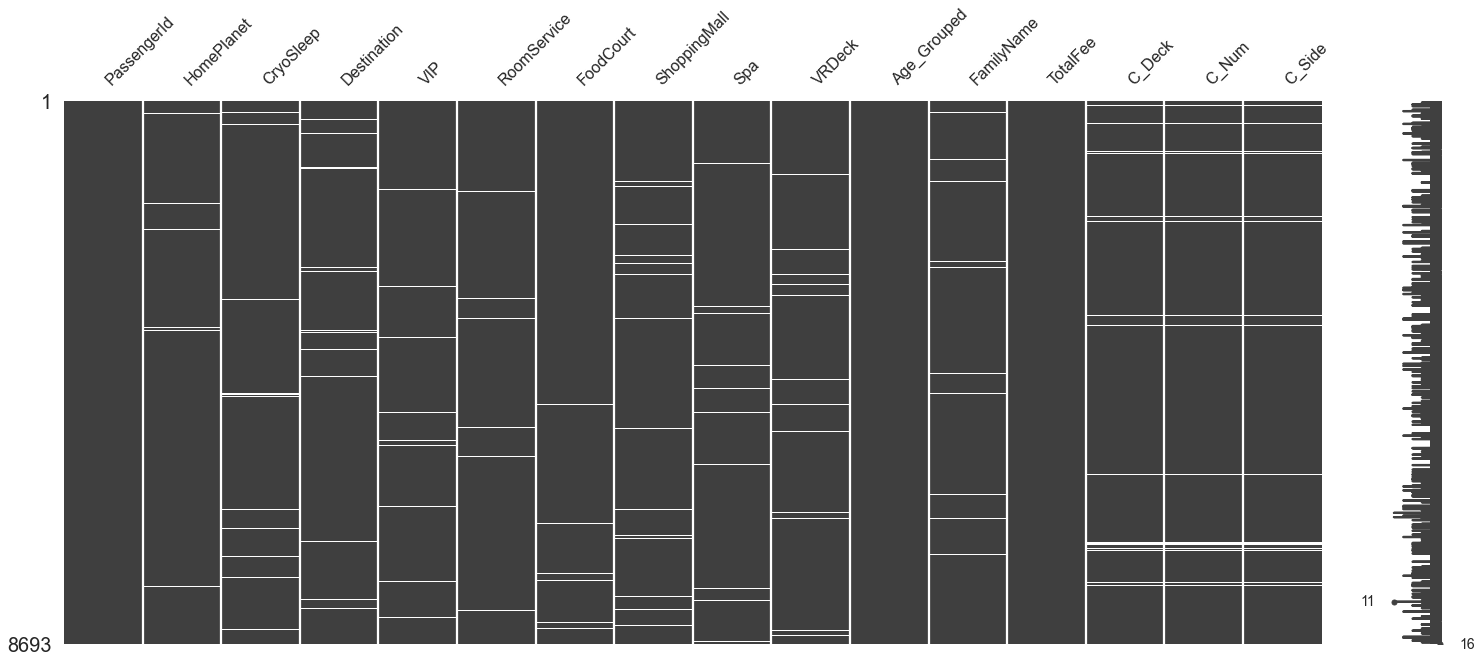

In [125]:
def split_cabin(the_str, index):
    if not isinstance(the_str, str):
        return None
    # Remove 'other' option
    the_str = the_str.upper()
    output = the_str.split("/")
    return output[index]

g_dataset['C_Deck'] = g_dataset.Cabin.apply(split_cabin, args=(0,))

g_dataset['C_Num'] = g_dataset.Cabin.apply(split_cabin, args=(1,))
# Ajuste del tipo de datos
g_dataset['C_Num'] = pd.to_numeric(g_dataset['C_Num'])

g_dataset['C_Side'] = g_dataset.Cabin.apply(split_cabin, args=(2,))

g_dataset.drop(['Cabin'], errors='ignore', axis=1, inplace=True)


msno.matrix(g_dataset);

### Exploracion de la variable Num

In [126]:
g_dataset.describe()['C_Num']

count    8494.000000
mean      600.367671
std       511.867226
min         0.000000
25%       167.250000
50%       427.000000
75%       999.000000
max      1894.000000
Name: C_Num, dtype: float64

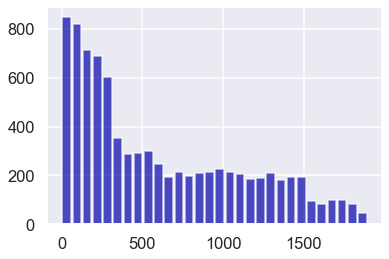

In [127]:
n, bins, patches = plt.hist(x=g_dataset['C_Num'], bins=30, color='#0504aa',
                            alpha=0.7, rwidth=0.85)

##
 - Se observa una distribución con tendencia decreciente con el número de asiento

## Proceso de imputación

## Imputación por la moda:
 - Aplicaremos este tipo de imputacion para las variables numericas: RoomService, FoodCourt, ShoppingMall, Spa, VRDeck, C_Num

RoomService
FoodCourt
ShoppingMall
Spa
VRDeck
C_Num


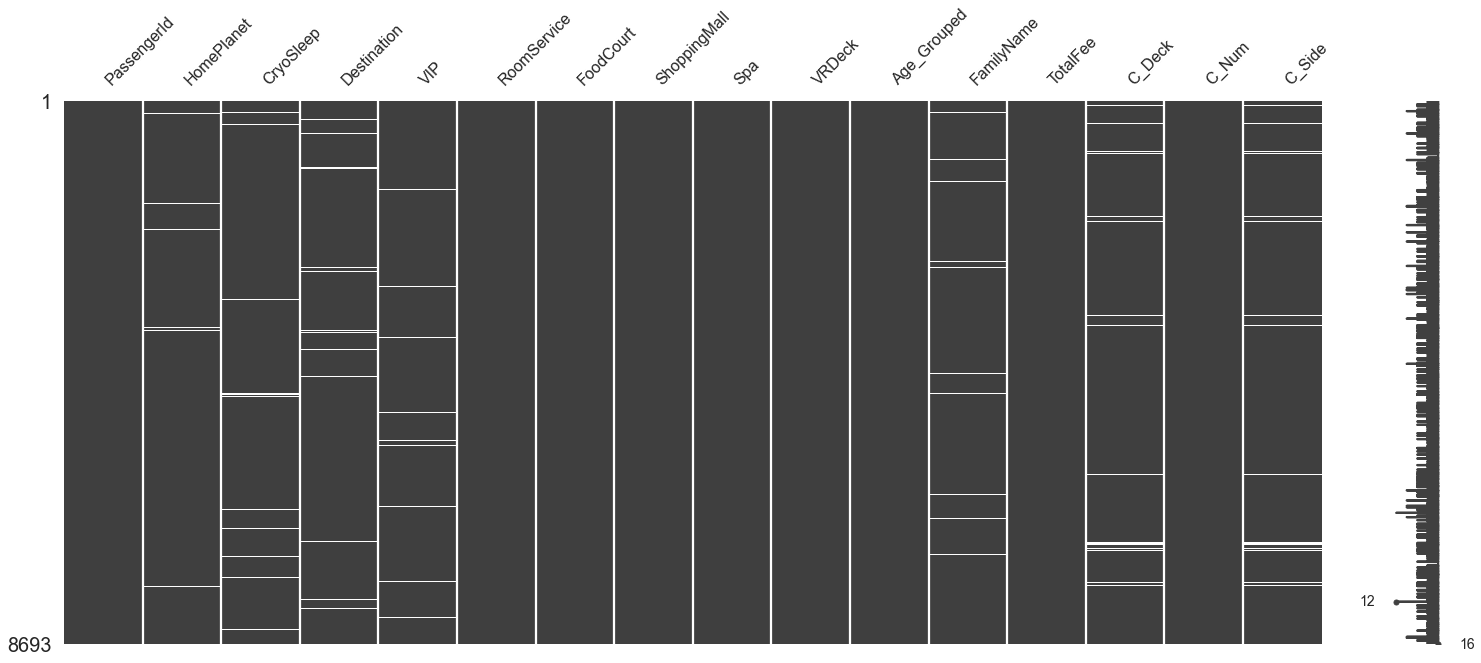

In [128]:
def mode_fill(df, columns=['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','C_Num']):
    for col in columns:
        print(col)
        df[col] = df[col].fillna(value = df[col].mode()[0])

    return df

g_dataset = mode_fill(g_dataset)
msno.matrix(g_dataset);

### Imputación aleatoria ponderada
Para cada variable categorica
 - Se Modela la distribución de frecuencias
 - A partir de las frecuencias relativas generamos un peso relativo
 - Se genera los valores faltantes en forma aleatoria pesando la probabilidad de cada caso según el peso relativo calculado en el paso anterior

In [129]:
# Preliminar: completamos las variables categorias con datos faltantes con la etiqueta "Unknown"
def set_Unknown():
    for col in g_dataset:
        if (g_dataset[col].dtype=="object"):
            g_dataset[col].fillna("Unknown", inplace=True)

set_Unknown()
g_dataset.isnull().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Destination     0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Age_Grouped     0
FamilyName      0
TotalFee        0
C_Deck          0
C_Num           0
C_Side          0
dtype: int64

#### Exploremos un poco cada variable

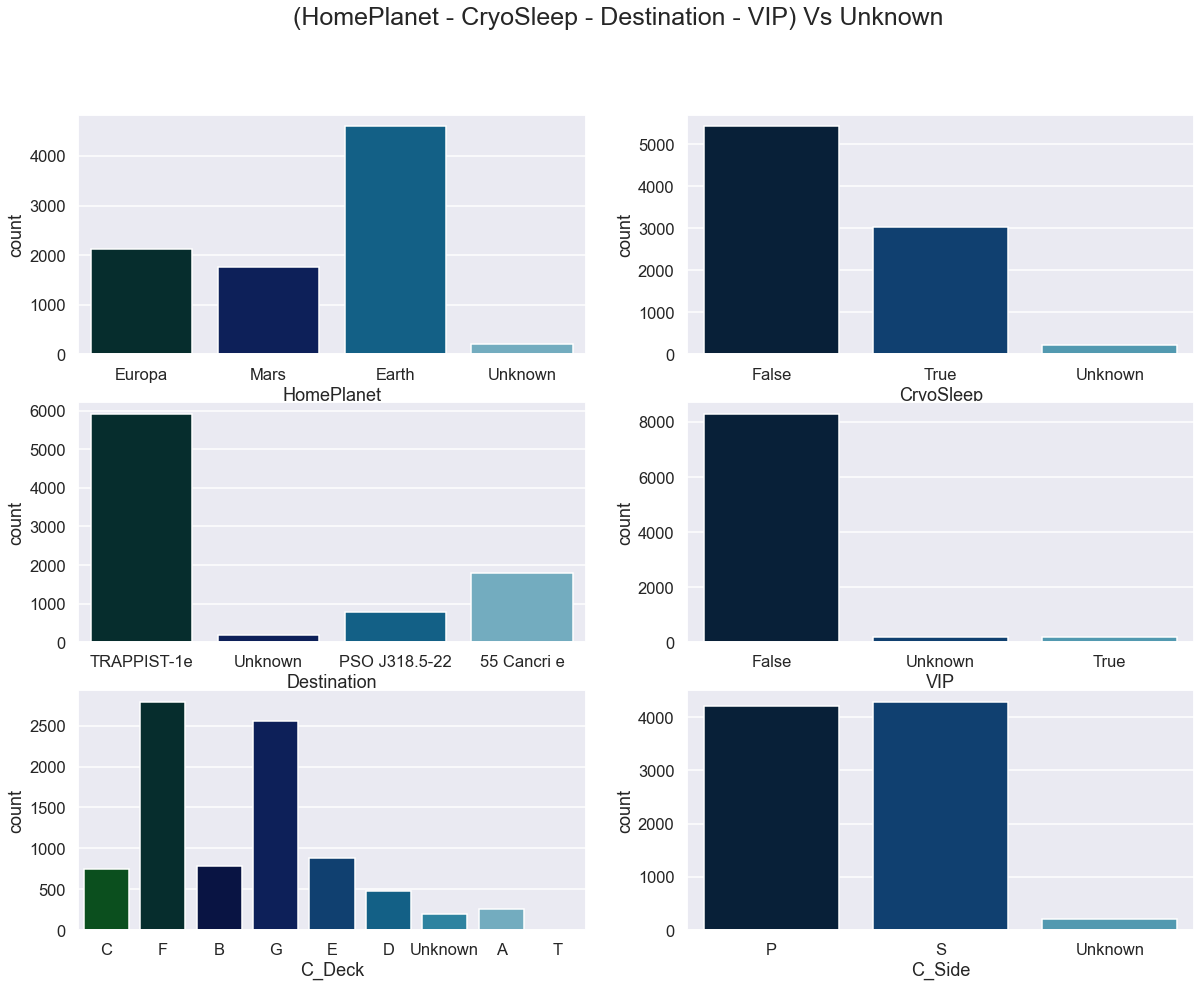

In [130]:
fig, axs = plt.subplots(nrows = 3, ncols = 2, sharex=False, sharey = False,figsize=(20,15))
sns.countplot(g_dataset["HomePlanet"], palette = "ocean", ax= axs[0,0])
sns.countplot(g_dataset["CryoSleep"], palette = "ocean", ax= axs[0,1])
sns.countplot(g_dataset["Destination"], palette = "ocean", ax= axs[1,0])
sns.countplot(g_dataset["VIP"], palette = "ocean", ax= axs[1,1])
sns.countplot(g_dataset["C_Deck"], palette = "ocean", ax= axs[2,0])
sns.countplot(g_dataset["C_Side"], palette = "ocean", ax= axs[2,1])
fig.suptitle("(HomePlanet - CryoSleep - Destination - VIP) Vs Unknown", fontsize=25);


###
- Se observa una distribución de pasajero con proporciones no uniformes.
- Los faltantes o nulos (Unknown) representan una reducida proporción del total

### Imputación: el algoritmo...
 - Se utiliza un diccionario como soporte
 - Para cada variable (clave) se registrar una lista con el peso relativo de cada etiqueta (valor)

#### Soporte para el computo de frecuencias

In [131]:
dic_val_weight={}

lista_labels = ["HomePlanet", "CryoSleep", "Destination", "VIP","FamilyName", "C_Deck", "C_Side"]
for unlabel in lista_labels:
    g_dataset[unlabel].replace({"Unknown": None},inplace=True)
    unicos = g_dataset[unlabel].value_counts() / \
             g_dataset[unlabel].value_counts().sum()
    dic_val_weight[unlabel] = unicos

# Regeneramos lo nulo prontos a imputar
set_Unknown()

#### Función auxiliar para imputar

In [132]:
def imputer(xx, patern):
   if (xx == "Unknown") or (xx==None):
        xx = random.choices(patern.index, weights=patern.values, k=1)[0]
   else:
       pass
   return xx

#### Ejecución del proceso de imputación al listado de variables previstas

In [133]:
for label in lista_labels:
    print(f"IMPUTACION PARA: {label}")
    print(f"---------------------------")
    filter = g_dataset[label] == "Unknown"
    print(f"Previo a inputar la cantidad de datos Unknown son= {filter.sum()}")
    g_dataset[label] = g_dataset[label].apply(imputer, args = (dic_val_weight[label],))
    filter = g_dataset[label] == "Unknown"
    print(f"Luego de imputar la cantidad de datos Unknown son= {filter.sum()}\n")
    print(f"Valores unicos: {g_dataset[label].unique()}\n")
    print(f"Recalculo de % After:\n{g_dataset[label].value_counts() / g_dataset[label].value_counts().sum()}\n")
    print(f"Distrib before:\n{dic_val_weight[label]}")
    print(f"\n \n")


IMPUTACION PARA: HomePlanet
---------------------------
Previo a inputar la cantidad de datos Unknown son= 201
Luego de imputar la cantidad de datos Unknown son= 0

Valores unicos: ['Europa' 'Mars' 'Earth']

Recalculo de % After:
Earth     0.542275
Europa    0.250776
Mars      0.206948
Name: HomePlanet, dtype: float64

Distrib before:
Earth     0.541922
Europa    0.250942
Mars      0.207136
Name: HomePlanet, dtype: float64

 

IMPUTACION PARA: CryoSleep
---------------------------
Previo a inputar la cantidad de datos Unknown son= 217
Luego de imputar la cantidad de datos Unknown son= 0

Valores unicos: [False  True]

Recalculo de % After:
False    0.642816
True     0.357184
Name: CryoSleep, dtype: float64

Distrib before:
False    0.641694
True     0.358306
Name: CryoSleep, dtype: float64

 

IMPUTACION PARA: Destination
---------------------------
Previo a inputar la cantidad de datos Unknown son= 182
Luego de imputar la cantidad de datos Unknown son= 0

Valores unicos: ['TRAPPIST-1e

### Visualización de los resultados de las imputaciones realizadas

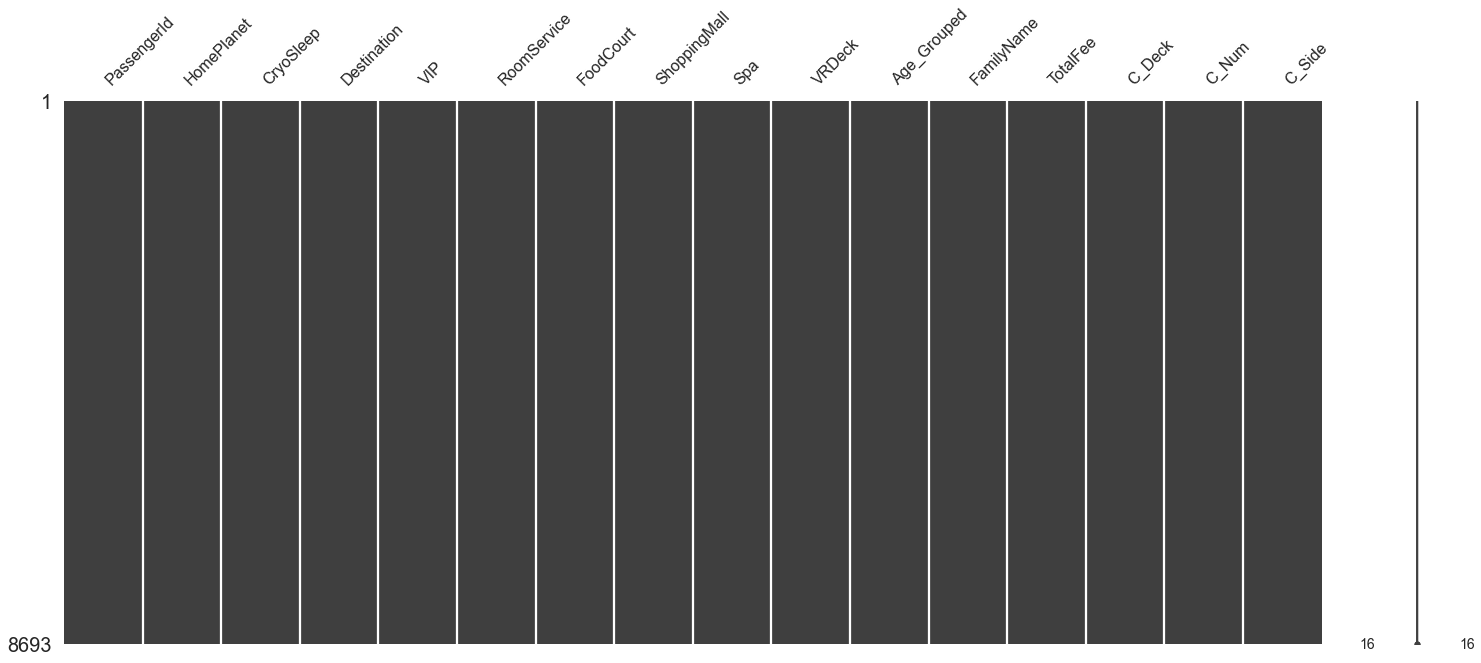

In [134]:
msno.matrix(g_dataset);

###
 - Eliminamos el PassengerId del set de datos
 - Es un valor numérico único y no aporta en principio información significativa al modelo

In [135]:
g_dataset.drop(['PassengerId'], errors='ignore', axis=1, inplace=True)

### Ajuste de tipos

In [136]:
g_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8693 entries, 0 to 869
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   HomePlanet    8693 non-null   object  
 1   CryoSleep     8693 non-null   bool    
 2   Destination   8693 non-null   object  
 3   VIP           8693 non-null   bool    
 4   RoomService   8693 non-null   float64 
 5   FoodCourt     8693 non-null   float64 
 6   ShoppingMall  8693 non-null   float64 
 7   Spa           8693 non-null   float64 
 8   VRDeck        8693 non-null   float64 
 9   Age_Grouped   8693 non-null   category
 10  FamilyName    8693 non-null   object  
 11  TotalFee      8693 non-null   float64 
 12  C_Deck        8693 non-null   object  
 13  C_Num         8693 non-null   float64 
 14  C_Side        8693 non-null   object  
dtypes: bool(2), category(1), float64(7), object(5)
memory usage: 908.7+ KB


### Encoding de variables booleanas
 - Transformación de variables booleanas a numéricas

In [137]:
g_dataset['VIP'].replace({False: 0, True: 1},inplace=True)
g_dataset['CryoSleep'].replace({False: 0, True: 1},inplace=True)

### Encoding de variables categóricas.
 - Dada una variable se generan nuevas variables derivadas de esta una por cada etiqueta asociada.
 - Se utiliza la función get_dummies de Pandas
 - Se elimina la variable categorica original. La misma queda representada en el set de datos por las nuevas variables generadas

#### HomePlanet

In [138]:
dummies_HomePlanet = pd.get_dummies(g_dataset.HomePlanet)
dummies_HomePlanet_df = pd.DataFrame(dummies_HomePlanet, columns=g_dataset.HomePlanet.unique())
dummies_HomePlanet_df.columns

Index(['Europa', 'Mars', 'Earth'], dtype='object')

In [139]:
g_dataset["HomePlanet_Europa"]=dummies_HomePlanet_df["Europa"]
g_dataset["HomePlanet_Earth"]=dummies_HomePlanet_df["Earth"]
g_dataset["HomePlanet_Mars"]=dummies_HomePlanet_df["Mars"]
g_dataset.drop(['HomePlanet'], errors='ignore', axis=1, inplace=True)

#### Destination

In [140]:
dummies_Destination = pd.get_dummies(g_dataset.Destination)
dummies_Destination_df = pd.DataFrame(dummies_Destination, columns=g_dataset.Destination.unique())
dummies_Destination_df.columns

Index(['TRAPPIST-1e', 'PSO J318.5-22', '55 Cancri e'], dtype='object')

In [141]:
g_dataset["Destination_TRAPPIST-1e"]=dummies_Destination_df["TRAPPIST-1e"]
g_dataset["Destination_PSO J318.5-22"]=dummies_Destination_df["PSO J318.5-22"]
g_dataset["Destination_55 Cancri e"]=dummies_Destination_df["55 Cancri e"]
g_dataset.drop(['Destination'], errors='ignore', axis=1, inplace=True)

#### Age_Grouped

In [142]:
dummies_Age_Grouped = pd.get_dummies(g_dataset.Age_Grouped)
dummies_Age_Grouped_df = pd.DataFrame(dummies_Age_Grouped, columns=g_dataset.Age_Grouped.unique())
dummies_Age_Grouped_df.columns

CategoricalIndex(['Father', 'Student', 'YoungAdult', 'Young', 'Adult',
                  'Unknown', 'GrandFather', 'HightSchool', 'Kinder', 'School'],
                 categories=['Unknown', 'Kinder', 'School', 'HightSchool', 'Student', 'Young', 'YoungAdult', 'Adult', ...], ordered=True, dtype='category')

In [143]:
g_dataset['Father']=dummies_Age_Grouped_df['Father']
g_dataset['Student']=dummies_Age_Grouped_df['Student']
g_dataset['YoungAdult']=dummies_Age_Grouped_df['YoungAdult']
g_dataset['Young']=dummies_Age_Grouped_df['Young']
g_dataset['Adult']=dummies_Age_Grouped_df['Adult']

g_dataset['Unknown']=dummies_Age_Grouped_df['Unknown']
g_dataset['GrandFather']=dummies_Age_Grouped_df['GrandFather']
g_dataset['HightSchool']=dummies_Age_Grouped_df['HightSchool']
g_dataset['Kinder']=dummies_Age_Grouped_df['Kinder']
g_dataset['School']=dummies_Age_Grouped_df['School']
g_dataset.drop(['Age_Grouped'], errors='ignore', axis=1, inplace=True)


#### C_Deck

In [144]:
dummies_C_Deck = pd.get_dummies(g_dataset.C_Deck)
dummies_C_Deck_df = pd.DataFrame(dummies_C_Deck, columns=g_dataset.C_Deck.unique())
dummies_C_Deck_df.columns

Index(['C', 'F', 'B', 'G', 'E', 'D', 'A', 'T'], dtype='object')

In [145]:
g_dataset["C_Deck_B"]=dummies_C_Deck_df["B"]
g_dataset["C_Deck_F"]=dummies_C_Deck_df["F"]
g_dataset["C_Deck_A"]=dummies_C_Deck_df["A"]
g_dataset["C_Deck_G"]=dummies_C_Deck_df["G"]
g_dataset["C_Deck_C"]=dummies_C_Deck_df["C"]
g_dataset["C_Deck_E"]=dummies_C_Deck_df["E"]
g_dataset["C_Deck_D"]=dummies_C_Deck_df["D"]
g_dataset["C_Deck_T"]=dummies_C_Deck_df["T"]
g_dataset.drop(['C_Deck'], errors='ignore', axis=1, inplace=True)

#### C_Side

In [146]:
dummies_C_Side = pd.get_dummies(g_dataset.C_Side)
dummies_C_Side_df = pd.DataFrame(dummies_C_Side, columns=g_dataset.C_Side.unique())
dummies_C_Side_df.columns

Index(['P', 'S'], dtype='object')

In [147]:
g_dataset["C_Side_P"]=dummies_C_Side_df["P"]
g_dataset["C_Side_S"]=dummies_C_Side_df["S"]
g_dataset.drop(['C_Side'], errors='ignore', axis=1, inplace=True)

### FamilyName - Label enconder
 - FamilyName: Se aplica Label enconder.
 - Consideramos no procedente aplicar el metodo get_dummies dado que generaria una cantidad significativa de nuevas variables.

In [148]:
dummies_FamilyName = pd.get_dummies(g_dataset.FamilyName)
dummies_FamilyName_df = pd.DataFrame(dummies_FamilyName, columns=g_dataset.FamilyName.unique())
dummies_FamilyName_df.columns

Index(['Tronsive', 'Sha', 'Tinganking', 'Grifford', 'Dunnisey', 'Dickley',
       'Dutte', 'Bruthydre', 'Clemondsey', 'Carverson',
       ...
       'Oirmplathy', 'Bartins', 'Read', 'Stelative', 'Steen', 'Cotik',
       'Wassid', 'Tre', 'Fuleng', 'Rochan'],
      dtype='object', length=2217)

In [149]:
g_dataset["FamilyName"].head()

0      Tronsive
1           Sha
2    Tinganking
3      Grifford
4      Dunnisey
Name: FamilyName, dtype: object

In [150]:
label_encoder = LabelEncoder()
label_encoder.fit(g_dataset["FamilyName"])
g_dataset["FamilyName"]= label_encoder.transform(g_dataset["FamilyName"])


In [151]:
g_dataset["FamilyName"].head()

0    2057
1    1825
2    2034
3     891
4     626
Name: FamilyName, dtype: int32

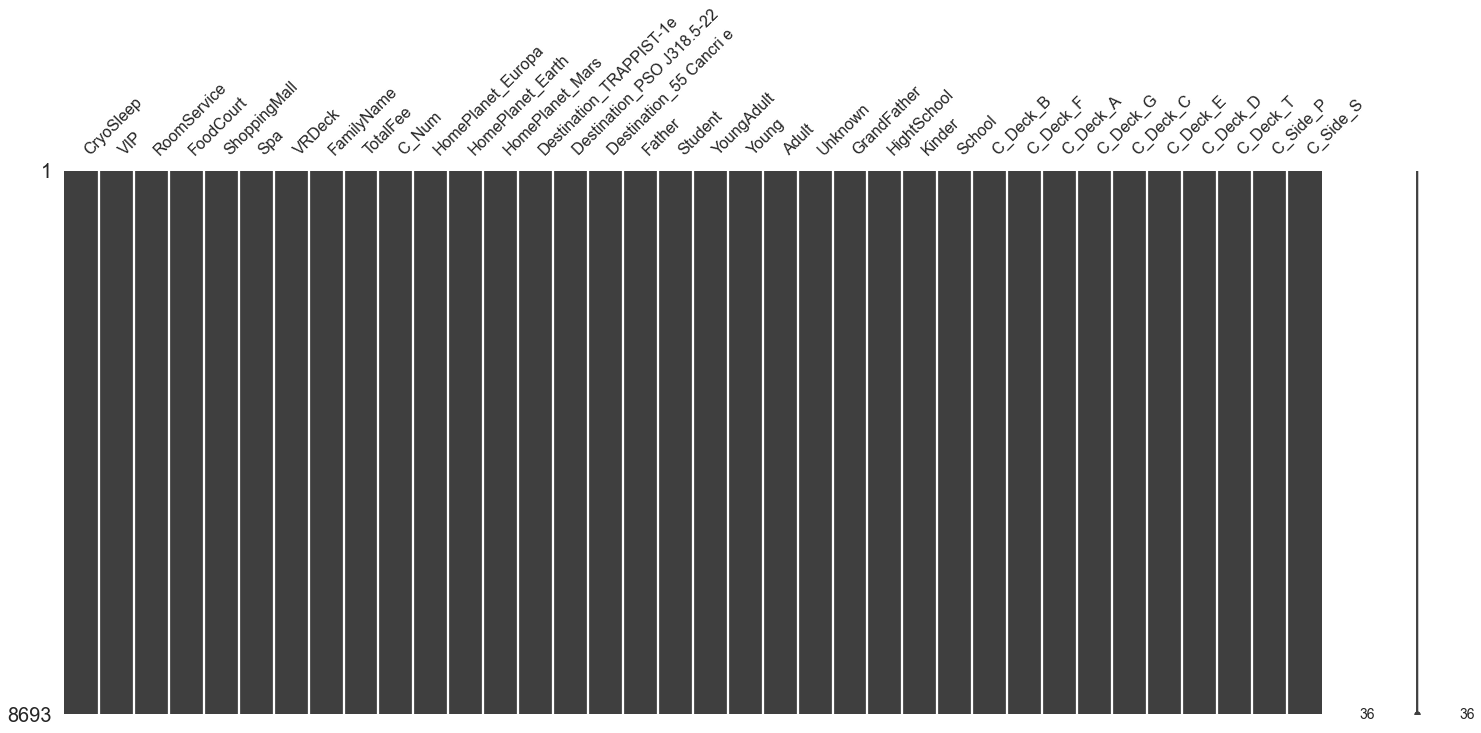

In [152]:
msno.matrix(g_dataset);

### Auditoria final de imputación y tipos de datos

In [153]:
g_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8693 entries, 0 to 869
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CryoSleep                  8693 non-null   int64  
 1   VIP                        8693 non-null   int64  
 2   RoomService                8693 non-null   float64
 3   FoodCourt                  8693 non-null   float64
 4   ShoppingMall               8693 non-null   float64
 5   Spa                        8693 non-null   float64
 6   VRDeck                     8693 non-null   float64
 7   FamilyName                 8693 non-null   int32  
 8   TotalFee                   8693 non-null   float64
 9   C_Num                      8693 non-null   float64
 10  HomePlanet_Europa          8693 non-null   uint8  
 11  HomePlanet_Earth           8693 non-null   uint8  
 12  HomePlanet_Mars            8693 non-null   uint8  
 13  Destination_TRAPPIST-1e    8693 non-null   uint8 

### Analisis de correlación en el espacio de atributos preparado para el desarrollo del modelo de clasificación

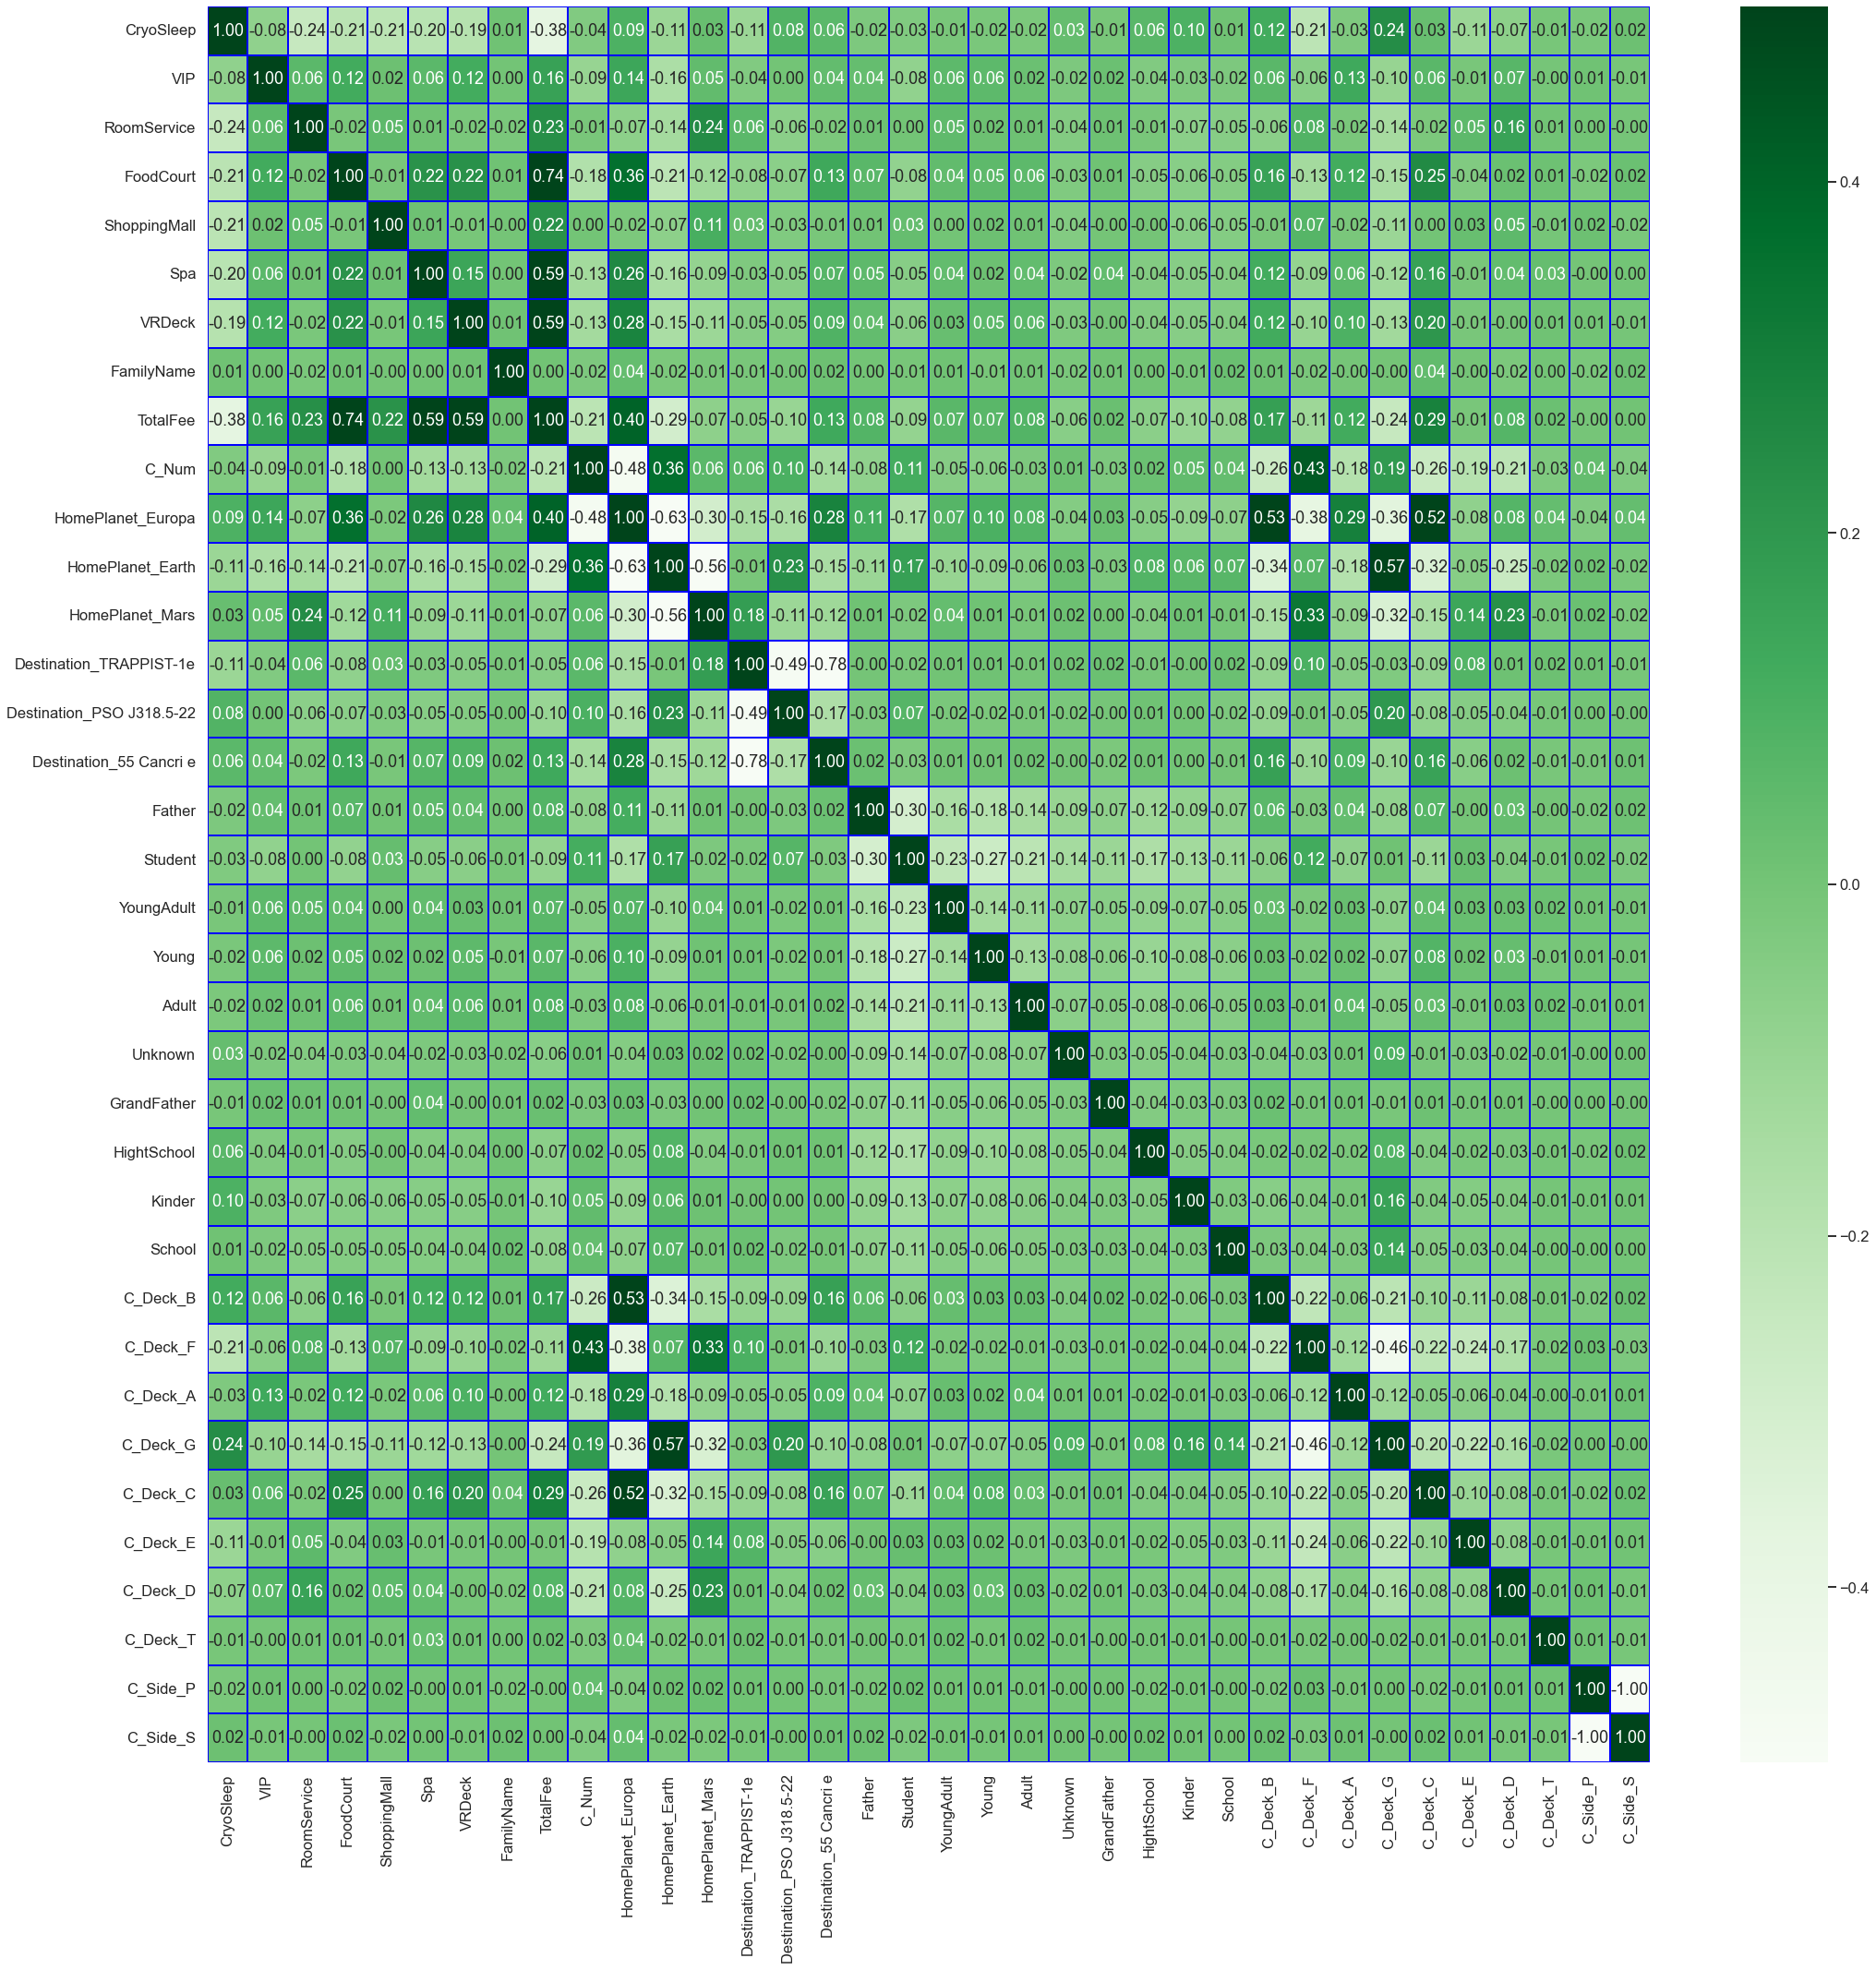

In [154]:
f,ax = plt.subplots(figsize=(35, 35))
sns.heatmap(g_dataset.corr(), annot=True, linewidths=0.2,linecolor="blue", fmt= '.2f',ax=ax, cmap="Greens",vmin=-0.5, vmax=0.5)
plt.show()

### Se observan clusters de correlación en el conjunto final de datos curados.
 - Induce a un estudio de reducción de dimensionalidad PCA. No realizado.

### Almacenamiento con persistencia de g_dataset "curado"
 - El archivo g_dataset_c.csv contiene el set de datos luego del proceso de curado
 - Este archivo sera el utilizado para la creación de los modelos de clasificación

In [155]:
g_dataset.to_csv('g_dataset_c.csv', index=False)
g_dataset_test = pd.read_csv('g_dataset_c.csv')

———–FINAL PARTE 2 de 5————–